In [ ]:
#importação da biblioteca do kaggle para realizar o download do dataset através da API. 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip archieve.zip
!unzip face-mask-detection.zip

In [ ]:
#definição da versão 1 do tensorflow que é compatível com a biblioteca
%tensorflow_version 1.x
#clone da biblioteca
!git clone https://github.com/Jefferson023/Mask_RCNN
%cd Mask_RCNN
#instalação dos requisitos da biblioteca
!python setup.py install
#download dos pesos pré-treinados em um modelo usando o dataset COCO
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#criação de um diretório para armazenar os pesos do modelo treinado
!mkdir logs

TensorFlow 1.x selected.
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 964 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (964/964), 125.25 MiB | 36.35 MiB/s, done.
Resolving deltas: 100% (563/563), done.
/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> buil

In [ ]:
#importação das bibliotecas que serão utilizadas
import numpy as np
from xml.etree import ElementTree
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt
from os import listdir
import random

In [ ]:
#criação de uma classe de configuração customizada
class CustomConfig(Config):
    NAME = "mask_detection"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    IMAGE_MIN_DIM = 448
    BATCH_SIZE = 1
    IMAGE_MAX_DIM = 704
    NUM_CLASSES = 1 + 3 #background + as três classes
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.7
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    BACKBONE = 'resnet50'

#criação de uma classe para carregar lidar com dataset 
class MaskDataset(utils.Dataset):  
  #função responsável por carregar as imagens e separar em conjuntos de treino e teste  
  def load_dataset(self, dataset_dir, is_train=True):
    self.add_class("mask_detection", 1, "without_mask")
    self.add_class("mask_detection", 2, "with_mask")
    self.add_class("mask_detection", 3, "mask_weared_incorrect")

    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annotations/maksssksksss'
    total_of_images = len(list(listdir(images_dir)))
    test_index = total_of_images - total_of_images*0.1 #separa 10% da base de dados como treinamento

    for filename in listdir(images_dir):
      image_id = int("".join(list(filter(str.isdigit, filename))))

      # pula todas as imagens depois do indice de teste caso seja treino
      if is_train and image_id > test_index:
          continue
      # pula todas as imagens antes do indice de teste caso seja teste
      if not is_train and int(image_id) < test_index:
          continue
      image_path = images_dir + filename
      ann_path = annotations_dir + str(image_id) + '.xml'

      self.add_image('mask_detection', image_id=image_id, path=image_path , annotation=ann_path, class_ids=[0,1,2,3])

  #função que procura as bounding boxes no arquivo xml
  def find_bounding_boxes(self, path_annotations):
    tree = ElementTree.parse(path_annotations)
    root = tree.getroot()
    boxes = []
    for box in root.findall('.//object'):
      name = box.find('name').text
      xmin = int(box.find('./bndbox/xmin').text)
      ymin = int(box.find('./bndbox/ymin').text)
      xmax = int(box.find('./bndbox/xmax').text)
      ymax = int(box.find('./bndbox/ymax').text)
      boxes.append([xmin, ymin, xmax, ymax, name])

    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)  
    return boxes, width, height

  #função que devolve as bounding boxes com as classes ao qual pertencem
  def load_mask(self, image_id):
    path = self.image_info[image_id]['annotation']
    boxes, w, h = self.find_bounding_boxes(path)
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    class_ids = []
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      
      if (box[4] == "without_mask"):
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index("without_mask"))
      elif (box[4] == "with_mask"):
        masks[row_s:row_e, col_s:col_e, i] = 2
        class_ids.append(self.class_names.index("with_mask"))  
      else:
        masks[row_s:row_e, col_s:col_e, i] = 3
        class_ids.append(self.class_names.index("mask_weared_incorrect")) 

    return masks, np.asarray(class_ids, dtype='int32')

  #função que retorna o tamanho das imagens
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    if info["source"] == "shapes":
      return info["shapes"]
    else:
      super(self.__class__).image_reference(self, image_id)      

In [ ]:
config = CustomConfig()
COCO_WEIGHTS_PATH = "/content/Mask_RCNN/mask_rcnn_coco.h5"

train_dataset = MaskDataset()
train_dataset.load_dataset("/content/", is_train=True)
train_dataset.prepare()

test_dataset = MaskDataset()
test_dataset.load_dataset("/content/", is_train=False)
test_dataset.prepare()

#criação do modelo no modo treinamento
train_model = modellib.MaskRCNN(mode='training', config=config, model_dir= "/content/Mask_RCNN/logs")
#carrega os pesos do modelo COCO nesse modelo, revomendo algumas camadas que não serão utilizadas devido ao formato/tamanho das imagens
train_model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
#treina o modelo em 10 epochs para as primeiras camadas (parametro heads) do COCO. 
train_model.train(train_dataset, test_dataset,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/mask_detection20201216T0242/mask_rcnn_mask_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
100/100 [==============================] - 60s 596ms/step - loss: 1.8667 - val_loss: 0.8494

Epoch 2/10
100/100 [==============================] - 41s 406ms/step - loss: 1.2730 - val_loss: 0.8007
Epoch 3/10
100/100 [==============================] - 40s 399ms/step - loss: 1.1307 - val_loss: 0.7493
Epoch 4/10
100/100 [==============================] - 40s 402ms/step - loss: 1.0289 - val_loss: 1.1159
Epoch 5/10
100/100 [==============================] - 40s 399ms/step - loss: 0.9266 - val_loss: 0.4725
Epoch 6/10
100/100 [==============================] - 40s 400ms/step - loss: 0.8499 - val_loss: 0.2950
Epoch 7/10
100/100 [==============================] - 40s 401ms/step - loss: 0.7802 - val_loss: 0.2652
Epoch 8/10
100/100 [==============================] - 40s 399ms/step - loss: 0.7949 - val_loss: 1.1504
Epoch 9/10
100/100 [==============================] - 40s 401ms/step - loss: 0.7889 - val_loss: 0.7282
Epoch 10/10
100/100 [==============================] - 40s 399ms/step - 

In [ ]:
#criação do modelo no modo teste carregando os pesos da epoch 10
test_model = modellib.MaskRCNN(mode='inference', config=config, model_dir= "/content/Mask_RCNN/logs")
test_model.load_weights("/content/Mask_RCNN/logs/mask_detection20201216T0242/mask_rcnn_mask_detection_0010.h5", 
                        by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 10


Processing 1 images
image                    shape: (704, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  704.00000  int64
anchors                  shape: (1, 123420, 4)        min:   -0.25750  max:    1.21198  float32


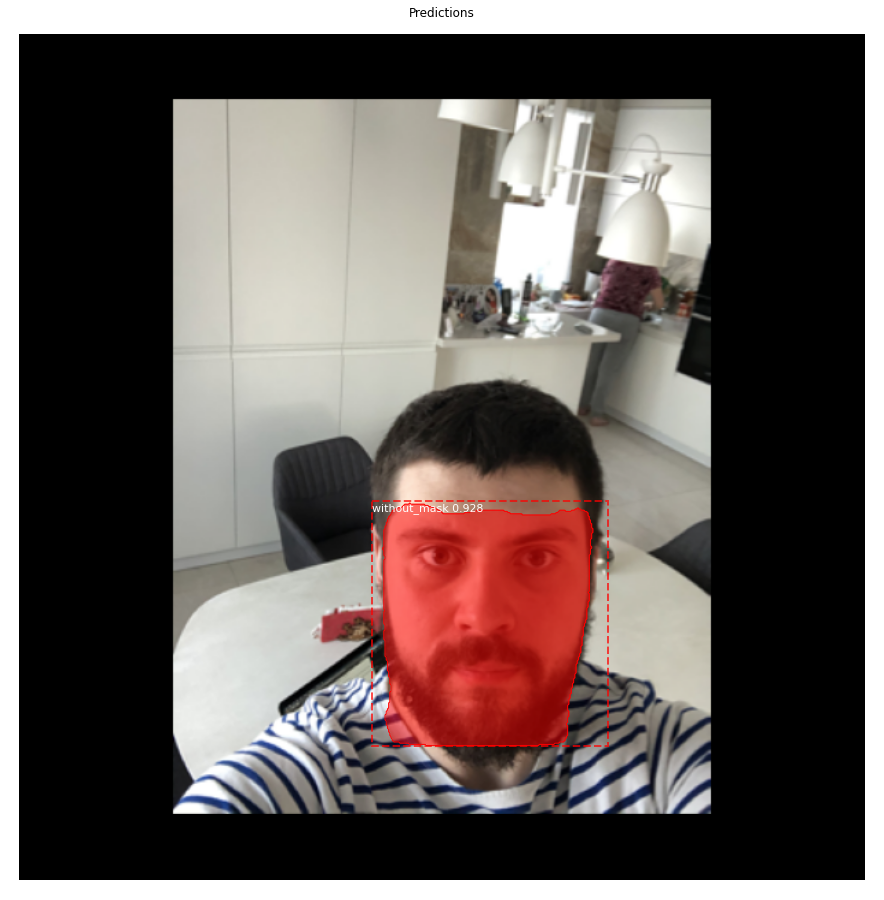

In [ ]:
#seleção de uma imagem aleatória
image_id = random.choice(test_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_dataset, config, image_id, use_mini_mask=False)

#predição das bounding boxes e classes dessa imagem
results = test_model.detect([image], verbose=1)

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

ax = get_ax(1)
r = results[0]

#visualização dessa imagem
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

Processing 1 images
image                    shape: (704, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  704.00000  int64
anchors                  shape: (1, 123420, 4)        min:   -0.25750  max:    1.21198  float32


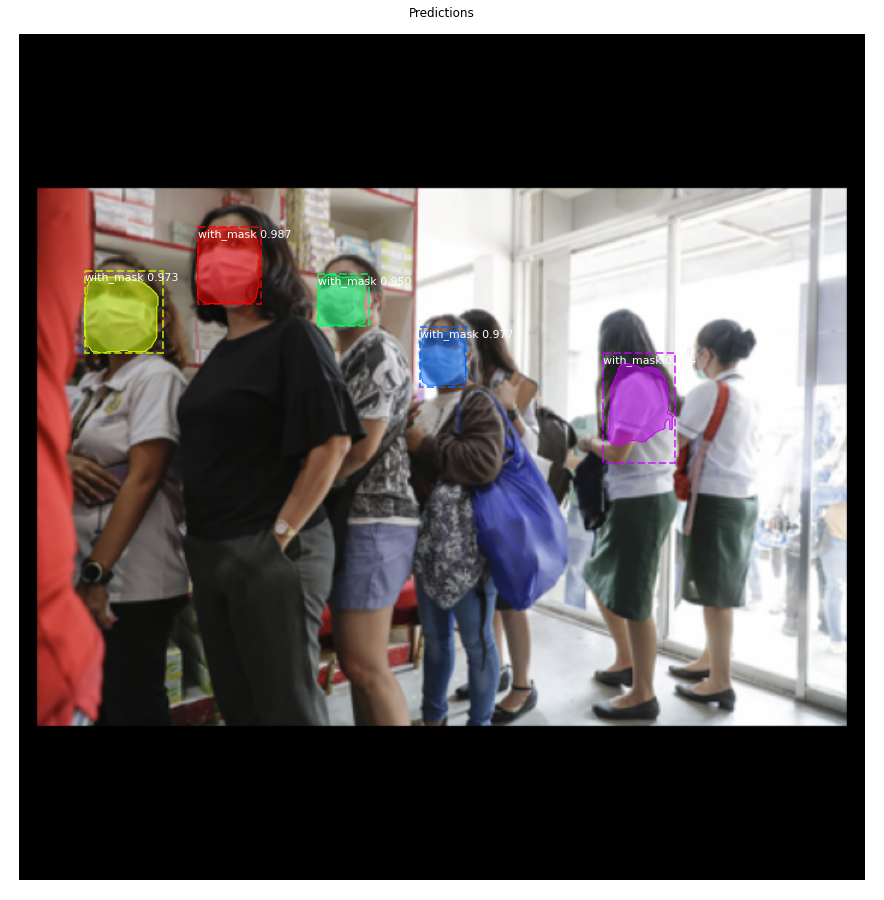

In [ ]:
image_id = random.choice(test_dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_dataset, config, image_id, use_mini_mask=False)

results = test_model.detect([image], verbose=1)

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

ax = get_ax(1)
r = results[0]

display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")